# Parallel Programming in Computational Physics

**Lecture 6 - November 7, 2025**

## Overview

In this lecture, we will explore parallel programming techniques for computational physics:

### Topics Covered:
1. **Introduction to Parallel Computing**
   - Why parallel computing?
   - Types of parallelism
   - Amdahl's Law

2. **Python Parallel Programming**
   - Multithreading (`threading`)
   - Multiprocessing (`multiprocessing`)
   - Process Pools
   
3. **Message Passing Interface (MPI)**
   - MPI basics with `mpi4py`
   - Point-to-point communication
   - Collective communication

4. **Practical Examples**
   - Monte Carlo π calculation (embarrassingly parallel)
   - 2D Heat Equation (domain decomposition with communication)

### Learning Objectives:
- Understand different parallel programming paradigms
- Implement parallel algorithms in Python
- Measure and analyze parallel efficiency
- Choose appropriate parallelization strategies

## Part 1: Introduction to Parallel Computing

### Why Parallel Computing?

**Moore's Law is slowing down:**
- Single-core performance gains have plateaued
- Modern computers have multiple cores (4-64+ cores)
- To leverage modern hardware, we need parallel programming

**Scientific Computing Benefits:**
- Solve larger problems
- Get results faster
- Explore more parameter space
- Real-time simulations

### Types of Parallelism

1. **Task Parallelism**: Different tasks run simultaneously
2. **Data Parallelism**: Same operation on different data
3. **Pipeline Parallelism**: Data flows through stages

### Amdahl's Law

If a program has a fraction `f` that must be serial, the maximum speedup with `N` processors is:

$$S(N) = \frac{1}{(1-f) + \frac{f}{N}}$$

**Key Insight**: Even small serial portions limit speedup!

Example: If 5% of code is serial, max speedup ≈ 20× regardless of processors.

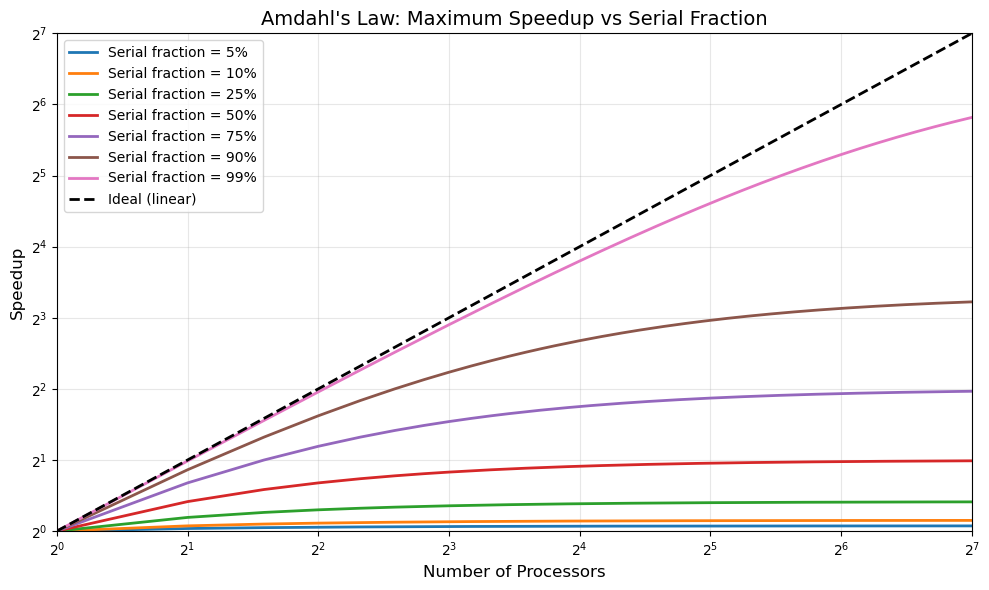

Key Takeaway: Even 5% serial code limits speedup to ~20×


In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Visualize Amdahl's Law
def amdahl_speedup(f, N):
    """Calculate speedup according to Amdahl's Law
    f: fraction of serial code
    N: number of processors
    """
    return 1 / ((1 - f) + f / N)

N_range = np.arange(1, 129)
f_values = [0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.99]

plt.figure(figsize=(10, 6))
for f in f_values:
    speedup = [amdahl_speedup(f, N) for N in N_range]
    plt.plot(N_range, speedup, label=f'Serial fraction = {f:.0%}', linewidth=2)

plt.plot(N_range, N_range, 'k--', label='Ideal (linear)', linewidth=2)
plt.xlabel('Number of Processors', fontsize=12)
plt.ylabel('Speedup', fontsize=12)
plt.title("Amdahl's Law: Maximum Speedup vs Serial Fraction", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim(1, 128)
plt.ylim(1, 128)
plt.xscale('log', base=2)
plt.yscale('log', base=2)
plt.tight_layout()
plt.show()

print("Key Takeaway: Even 5% serial code limits speedup to ~20×")

## Part 2: Python Parallel Programming

### 2.1 Multithreading

**Threads** share the same memory space within a process.

**Important: Python Global Interpreter Lock (GIL)**
- Only one thread executes Python bytecode at a time
- Threading is good for I/O-bound tasks (file, network)
- **NOT effective for CPU-bound tasks** in pure Python
- Can work for CPU tasks if using NumPy/SciPy (releases GIL)

In [27]:
import threading
import time

def cpu_bound_task(n):
    """CPU-intensive task: compute sum of squares"""
    total = 0
    for i in range(n):
        total += i * i
    return total

# Sequential execution
print("Sequential execution:")
start = time.time()
result1 = cpu_bound_task(10_000_000)
result2 = cpu_bound_task(10_000_000)
sequential_time = time.time() - start
print(f"Time: {sequential_time:.3f} seconds")

# Threading (with GIL)
print("\nThreading execution:")
start = time.time()
thread1 = threading.Thread(target=cpu_bound_task, args=(10_000_000,))
thread2 = threading.Thread(target=cpu_bound_task, args=(10_000_000,))
thread1.start()
thread2.start()
thread1.join()
thread2.join()
threading_time = time.time() - start
print(f"Time: {threading_time:.3f} seconds")

print(f"\nSpeedup: {sequential_time/threading_time:.2f}x")
print("Note: Threading shows little/no speedup for CPU-bound tasks due to GIL!")

Sequential execution:
Time: 0.868 seconds

Threading execution:
Time: 0.868 seconds

Threading execution:
Time: 0.829 seconds

Speedup: 1.05x
Note: Threading shows little/no speedup for CPU-bound tasks due to GIL!
Time: 0.829 seconds

Speedup: 1.05x
Note: Threading shows little/no speedup for CPU-bound tasks due to GIL!


### 2.2 Multiprocessing

**Processes** have separate memory spaces - **no GIL limitation!**

**Pros:**
- True parallelism for CPU-bound tasks
- Each process has its own Python interpreter
- Good for computational physics simulations

**Cons:**
- Higher memory overhead (separate memory)
- Communication between processes is slower
- More expensive to create/destroy

**Best for:** CPU-intensive scientific computing!

In [29]:
import multiprocessing as mp

def cpu_bound_task(n):
    """CPU-intensive task: compute sum of squares"""
    total = 0
    for i in range(n):
        total += i * i
    return total

if __name__ == '__main__':
    # Sequential execution
    print("Sequential execution:")
    start = time.time()
    result1 = cpu_bound_task(10_000_000)
    result2 = cpu_bound_task(10_000_000)
    sequential_time = time.time() - start
    print(f"Time: {sequential_time:.3f} seconds")
    
    # Multiprocessing
    print("\nMultiprocessing execution:")
    start = time.time()
    process1 = mp.Process(target=cpu_bound_task, args=(10_000_000,))
    process2 = mp.Process(target=cpu_bound_task, args=(10_000_000,))
    process1.start()
    process2.start()
    process1.join()
    process2.join()
    multiprocessing_time = time.time() - start
    print(f"Time: {multiprocessing_time:.3f} seconds")
    
    print(f"\nSpeedup: {sequential_time/multiprocessing_time:.2f}x")
    print("Multiprocessing shows real speedup for CPU-bound tasks!")

Sequential execution:
Time: 0.866 seconds

Multiprocessing execution:
Time: 0.866 seconds

Multiprocessing execution:
Time: 0.472 seconds

Speedup: 1.83x
Multiprocessing shows real speedup for CPU-bound tasks!
Time: 0.472 seconds

Speedup: 1.83x
Multiprocessing shows real speedup for CPU-bound tasks!


### 2.3 Process Pools

**Pool** provides a convenient way to parallelize function calls across multiple inputs.

**Key Methods:**
- `pool.map(func, iterable)`: Apply function to each element (blocking)
- `pool.apply_async(func, args)`: Asynchronous single call
- `pool.starmap(func, iterable)`: Like map but unpacks arguments

**Best Practice:** Use context manager (`with`) to ensure proper cleanup

In [30]:
def compute_square_sum(n):
    """Compute sum of squares up to n"""
    return sum(i*i for i in range(n))

# Create list of tasks
tasks = [5_000_000] * 8  # 8 tasks

# Sequential
print("Sequential execution:")
start = time.time()
results_seq = [compute_square_sum(n) for n in tasks]
seq_time = time.time() - start
print(f"Time: {seq_time:.3f} seconds")

# Parallel with Pool
print("\nParallel execution with Pool:")
n_cores = mp.cpu_count()
print(f"Using {n_cores} CPU cores")

start = time.time()
with mp.Pool(processes=n_cores) as pool:
    results_par = pool.map(compute_square_sum, tasks)
par_time = time.time() - start
print(f"Time: {par_time:.3f} seconds")

print(f"\nSpeedup: {seq_time/par_time:.2f}x")
print(f"Efficiency: {(seq_time/par_time)/n_cores*100:.1f}%")
print(f"Results match: {results_seq == results_par}")

Sequential execution:
Time: 1.859 seconds

Parallel execution with Pool:
Using 256 CPU cores
Time: 1.859 seconds

Parallel execution with Pool:
Using 256 CPU cores
Time: 1.079 seconds

Speedup: 1.72x
Efficiency: 0.7%
Results match: True
Time: 1.079 seconds

Speedup: 1.72x
Efficiency: 0.7%
Results match: True


## Part 3: Example 1 - Monte Carlo π Calculation

### The Problem

Estimate π using Monte Carlo method:
1. Generate random points in a unit square [0,1] × [0,1]
2. Count how many fall inside a quarter circle (radius = 1)
3. Ratio of points inside circle to total points ≈ π/4

$$\frac{\text{points inside circle}}{\text{total points}} \approx \frac{\pi/4}{1} = \frac{\pi}{4}$$

### Why This is "Embarrassingly Parallel"

- **No communication needed** between workers
- Each worker generates independent random samples
- Simply sum up results at the end
- **Perfect for demonstrating parallel efficiency**

### Expected Speedup

Near-linear with number of cores (very little overhead)

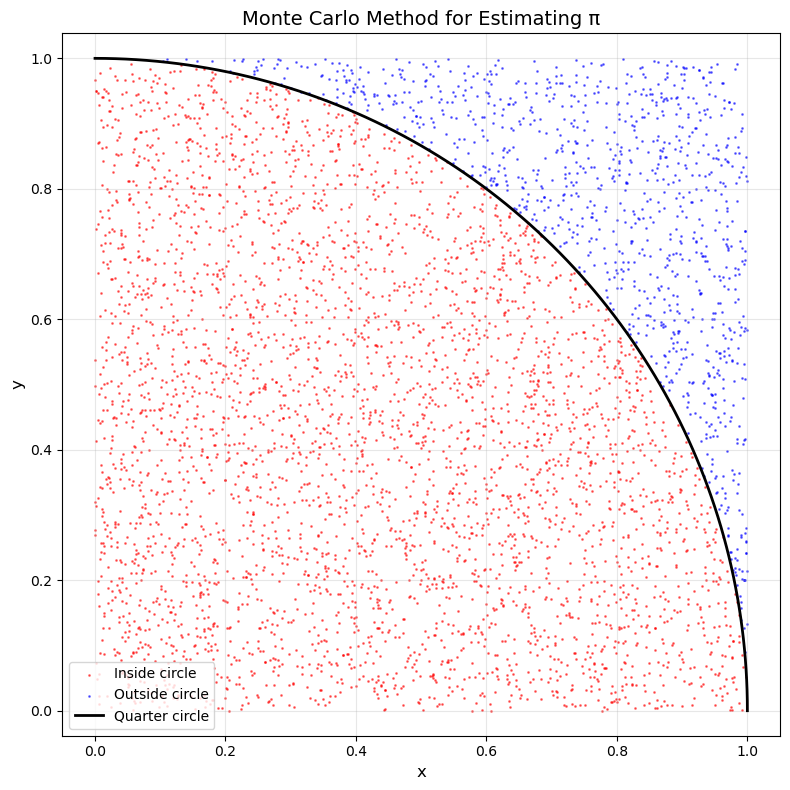

Points inside circle: 3969
Total points: 5000
π estimate: 3.175200
Actual π: 3.141593
Error: 0.033607


In [31]:
# Visualize the Monte Carlo method
np.random.seed(42)
n_visual = 5000

x = np.random.random(n_visual)
y = np.random.random(n_visual)
inside = (x**2 + y**2) <= 1.0

plt.figure(figsize=(8, 8))
plt.scatter(x[inside], y[inside], c='red', s=1, alpha=0.5, label='Inside circle')
plt.scatter(x[~inside], y[~inside], c='blue', s=1, alpha=0.5, label='Outside circle')

# Draw the quarter circle
theta = np.linspace(0, np.pi/2, 100)
plt.plot(np.cos(theta), np.sin(theta), 'k-', linewidth=2, label='Quarter circle')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Monte Carlo Method for Estimating π', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

pi_estimate = 4 * np.sum(inside) / n_visual
print(f"Points inside circle: {np.sum(inside)}")
print(f"Total points: {n_visual}")
print(f"π estimate: {pi_estimate:.6f}")
print(f"Actual π: {np.pi:.6f}")
print(f"Error: {abs(pi_estimate - np.pi):.6f}")

### Sequential Implementation

In [6]:
def monte_carlo_pi_sequential(n_samples):
    """Estimate pi using Monte Carlo method (sequential)"""
    inside = 0
    for _ in range(n_samples):
        x = np.random.random()
        y = np.random.random()
        if x*x + y*y <= 1.0:
            inside += 1
    return 4.0 * inside / n_samples

# Test with different sample sizes
print("Sequential Monte Carlo π Estimation")
print("=" * 50)
for n in [10**4, 10**5, 10**6, 10**7]:
    start = time.time()
    pi_est = monte_carlo_pi_sequential(n)
    elapsed = time.time() - start
    error = abs(pi_est - np.pi)
    print(f"N = {n:>10,}: π ≈ {pi_est:.6f}, Error = {error:.6f}, Time = {elapsed:.3f}s")

Sequential Monte Carlo π Estimation
N =     10,000: π ≈ 3.124800, Error = 0.016793, Time = 0.005s
N =    100,000: π ≈ 3.142680, Error = 0.001087, Time = 0.044s
N =  1,000,000: π ≈ 3.141880, Error = 0.000287, Time = 0.452s
N = 10,000,000: π ≈ 3.141526, Error = 0.000067, Time = 4.550s


### Parallel Implementation with Pool

In [7]:
def monte_carlo_pi_worker(n_samples):
    """Worker function: estimate pi for a chunk of samples"""
    np.random.seed()  # Important: each worker needs different seed
    x = np.random.random(n_samples)
    y = np.random.random(n_samples)
    inside = np.sum((x**2 + y**2) <= 1.0)
    return inside

def monte_carlo_pi_parallel(n_samples, n_processes):
    """Estimate pi using Monte Carlo method (parallel)"""
    # Divide work among processes
    samples_per_process = n_samples // n_processes
    tasks = [samples_per_process] * n_processes
    
    # Run in parallel
    with mp.Pool(processes=n_processes) as pool:
        results = pool.map(monte_carlo_pi_worker, tasks)
    
    # Combine results
    total_inside = sum(results)
    return 4.0 * total_inside / n_samples

# Test parallel version
n_cores = mp.cpu_count()
print(f"Parallel Monte Carlo π Estimation (using {n_cores} cores)")
print("=" * 50)

n_samples = 10**7
print(f"\nTesting with N = {n_samples:,} samples")
print("-" * 50)

# Sequential
start = time.time()
pi_seq = monte_carlo_pi_sequential(n_samples)
seq_time = time.time() - start
print(f"Sequential: π ≈ {pi_seq:.6f}, Time = {seq_time:.3f}s")

# Parallel
start = time.time()
pi_par = monte_carlo_pi_parallel(n_samples, n_cores)
par_time = time.time() - start
print(f"Parallel:   π ≈ {pi_par:.6f}, Time = {par_time:.3f}s")

print(f"\nSpeedup: {seq_time/par_time:.2f}x")
print(f"Efficiency: {(seq_time/par_time)/n_cores*100:.1f}%")

Parallel Monte Carlo π Estimation (using 256 cores)

Testing with N = 10,000,000 samples
--------------------------------------------------
Sequential: π ≈ 3.142589, Time = 4.544s
Parallel:   π ≈ 3.141604, Time = 0.878s

Speedup: 5.18x
Efficiency: 2.0%


### Scaling Analysis

Strong Scaling Analysis (Monte Carlo π)
Fixed problem size: N = 50,000,000 samples
------------------------------------------------------------
Processes:  1 | Time:  0.724s | Speedup:  1.00x | Efficiency: 100.0%
Processes:  2 | Time:  0.378s | Speedup:  1.91x | Efficiency:  95.7%
Processes:  4 | Time:  0.214s | Speedup:  3.38x | Efficiency:  84.6%
Processes:  8 | Time:  0.145s | Speedup:  4.98x | Efficiency:  62.3%


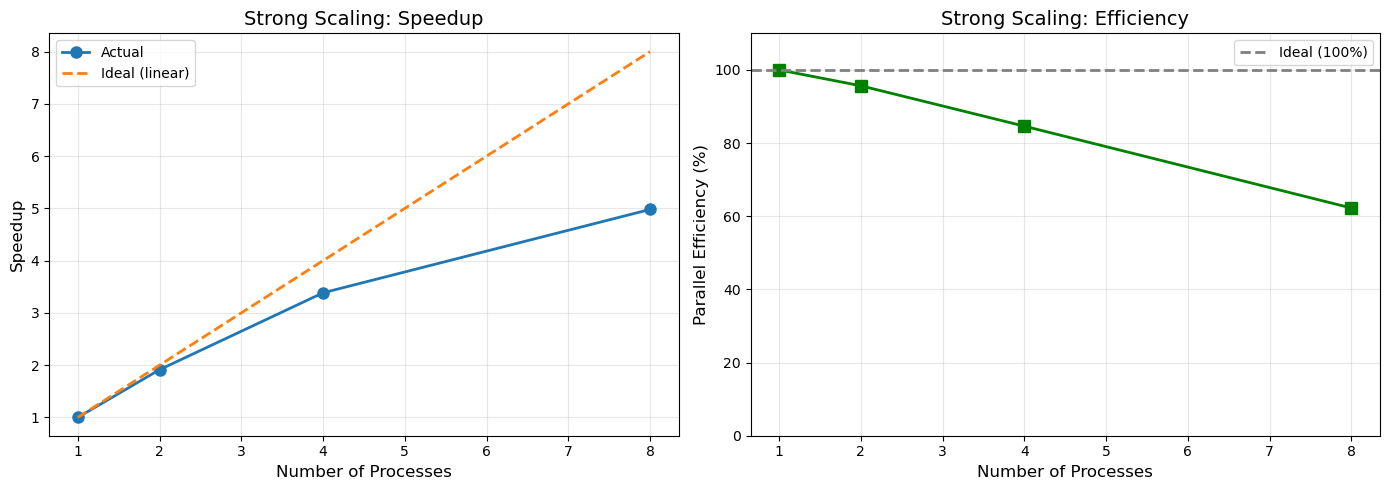


Conclusion: Near-linear scaling - embarrassingly parallel problem!


In [8]:
# Strong scaling: fixed problem size, vary number of processors
n_samples = 5 * 10**7
max_cores = mp.cpu_count()
n_processes_list = [1, 2, 4] + ([8] if max_cores >= 8 else [])

times = []
speedups = []
efficiencies = []

print("Strong Scaling Analysis (Monte Carlo π)")
print("=" * 60)
print(f"Fixed problem size: N = {n_samples:,} samples")
print("-" * 60)

for n_proc in n_processes_list:
    start = time.time()
    pi_est = monte_carlo_pi_parallel(n_samples, n_proc)
    elapsed = time.time() - start
    times.append(elapsed)
    
    speedup = times[0] / elapsed
    efficiency = speedup / n_proc * 100
    speedups.append(speedup)
    efficiencies.append(efficiency)
    
    print(f"Processes: {n_proc:2d} | Time: {elapsed:6.3f}s | "
          f"Speedup: {speedup:5.2f}x | Efficiency: {efficiency:5.1f}%")

# Plot scaling results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Speedup plot
ax1.plot(n_processes_list, speedups, 'o-', linewidth=2, markersize=8, label='Actual')
ax1.plot(n_processes_list, n_processes_list, '--', linewidth=2, label='Ideal (linear)')
ax1.set_xlabel('Number of Processes', fontsize=12)
ax1.set_ylabel('Speedup', fontsize=12)
ax1.set_title('Strong Scaling: Speedup', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Efficiency plot
ax2.plot(n_processes_list, efficiencies, 's-', linewidth=2, markersize=8, color='green')
ax2.axhline(y=100, linestyle='--', color='gray', linewidth=2, label='Ideal (100%)')
ax2.set_xlabel('Number of Processes', fontsize=12)
ax2.set_ylabel('Parallel Efficiency (%)', fontsize=12)
ax2.set_title('Strong Scaling: Efficiency', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 110)

plt.tight_layout()
plt.show()

print("\nConclusion: Near-linear scaling - embarrassingly parallel problem!")

## Part 4: Example 2 - 2D Heat Equation

### The Problem

Solve the 2D heat diffusion equation:

$$\frac{\partial T}{\partial t} = \alpha \left(\frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2}\right)$$

Using finite differences (explicit Euler):

$$T_{i,j}^{n+1} = T_{i,j}^{n} + \frac{\alpha \Delta t}{\Delta x^2} \left(T_{i+1,j}^{n} + T_{i-1,j}^{n} + T_{i,j+1}^{n} + T_{i,j-1}^{n} - 4T_{i,j}^{n}\right)$$

### Boundary Conditions

- Fixed temperature at boundaries
- Initial condition: hot spot in center

### Why This Requires Communication

- **Domain decomposition**: Split grid among processes
- Each process needs **ghost cells** from neighbors
- **Communication overhead** affects parallel efficiency
- Demonstrates the cost of inter-process communication

### Sequential Implementation

In [9]:
def heat_equation_2d_sequential(nx, ny, nt, alpha=0.01):
    """
    Solve 2D heat equation sequentially
    
    Parameters:
    -----------
    nx, ny : int
        Grid size in x and y directions
    nt : int
        Number of time steps
    alpha : float
        Thermal diffusivity coefficient
    """
    # Grid spacing
    dx = 1.0 / (nx - 1)
    dy = 1.0 / (ny - 1)
    dt = dx * dy / (4 * alpha)  # Stability condition
    
    # Initialize temperature field
    T = np.zeros((nx, ny))
    T_new = np.zeros((nx, ny))
    
    # Initial condition: hot spot in center
    center_x, center_y = nx // 2, ny // 2
    radius = min(nx, ny) // 10
    for i in range(nx):
        for j in range(ny):
            if (i - center_x)**2 + (j - center_y)**2 < radius**2:
                T[i, j] = 100.0
    
    # Boundary conditions (fixed at 0)
    T[0, :] = T[-1, :] = T[:, 0] = T[:, -1] = 0.0
    
    # Time stepping
    for n in range(nt):
        # Update interior points
        for i in range(1, nx-1):
            for j in range(1, ny-1):
                T_new[i, j] = T[i, j] + alpha * dt / dx**2 * (
                    T[i+1, j] + T[i-1, j] + T[i, j+1] + T[i, j-1] - 4*T[i, j]
                )
        
        # Keep boundaries fixed
        T_new[0, :] = T_new[-1, :] = T_new[:, 0] = T_new[:, -1] = 0.0
        
        # Swap arrays
        T, T_new = T_new, T
    
    return T

# Test sequential version
print("Sequential 2D Heat Equation")
print("=" * 50)

nx = ny = 200
nt = 500

start = time.time()
T_seq = heat_equation_2d_sequential(nx, ny, nt)
seq_time = time.time() - start

print(f"Grid size: {nx} × {ny}")
print(f"Time steps: {nt}")
print(f"Computation time: {seq_time:.3f} seconds")
print(f"Final max temperature: {np.max(T_seq):.2f}")
print(f"Final min temperature: {np.min(T_seq):.2f}")

Sequential 2D Heat Equation
Grid size: 200 × 200
Time steps: 500
Computation time: 14.416 seconds
Final max temperature: 54.73
Final min temperature: 0.00


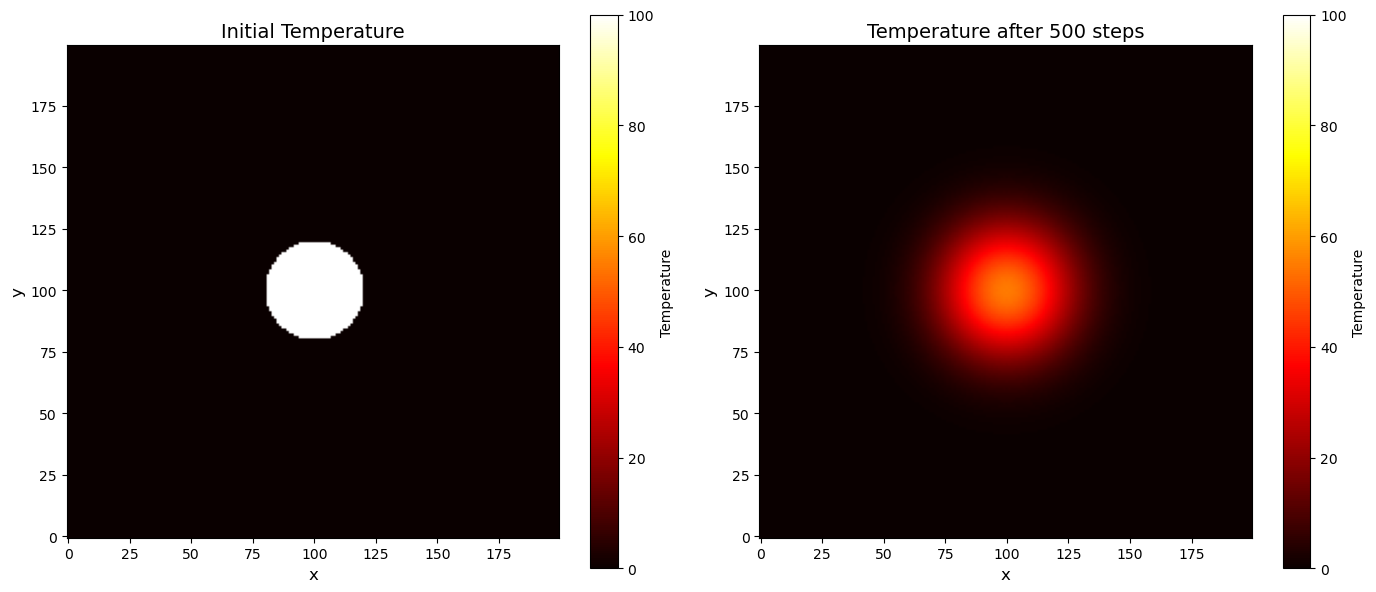

In [10]:
# Visualize the temperature field
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Initial condition
T_initial = np.zeros((nx, ny))
center_x, center_y = nx // 2, ny // 2
radius = min(nx, ny) // 10
for i in range(nx):
    for j in range(ny):
        if (i - center_x)**2 + (j - center_y)**2 < radius**2:
            T_initial[i, j] = 100.0

# Plot initial state
im1 = axes[0].imshow(T_initial.T, cmap='hot', origin='lower', vmin=0, vmax=100)
axes[0].set_title('Initial Temperature', fontsize=14)
axes[0].set_xlabel('x', fontsize=12)
axes[0].set_ylabel('y', fontsize=12)
plt.colorbar(im1, ax=axes[0], label='Temperature')

# Plot final state
im2 = axes[1].imshow(T_seq.T, cmap='hot', origin='lower', vmin=0, vmax=100)
axes[1].set_title(f'Temperature after {nt} steps', fontsize=14)
axes[1].set_xlabel('x', fontsize=12)
axes[1].set_ylabel('y', fontsize=12)
plt.colorbar(im2, ax=axes[1], label='Temperature')

plt.tight_layout()
plt.show()

### Parallel Implementation with Multiprocessing

We'll use **domain decomposition** along the x-axis:
- Each process handles a horizontal strip of the grid
- Processes need to exchange boundary rows (ghost cells)
- Use shared memory arrays for communication

In [17]:
def heat_step_worker(args):
    """Worker function for a single time step of heat equation"""
    T_current, start_row, end_row, nx, ny, alpha, dx, dy, dt = args
    
    T_new = np.zeros((nx, ny))
    
    # Update assigned rows
    for i in range(start_row, end_row):
        for j in range(1, ny-1):
            T_new[i, j] = T_current[i, j] + alpha * dt / dx**2 * (
                T_current[i+1, j] + T_current[i-1, j] + 
                T_current[i, j+1] + T_current[i, j-1] - 4*T_current[i, j]
            )
    
    return T_new[start_row:end_row, :]

def heat_equation_2d_parallel(nx, ny, nt, n_processes, alpha=0.01):
    """Solve 2D heat equation in parallel using multiprocessing Pool"""
    
    # Grid parameters
    dx = 1.0 / (nx - 1)
    dy = 1.0 / (ny - 1)
    dt = dx * dy / (4 * alpha)
    
    # Initialize temperature field
    T = np.zeros((nx, ny))
    center_x, center_y = nx // 2, ny // 2
    radius = min(nx, ny) // 10
    for i in range(nx):
        for j in range(ny):
            if (i - center_x)**2 + (j - center_y)**2 < radius**2:
                T[i, j] = 100.0
    
    # Boundary conditions
    T[0, :] = T[-1, :] = T[:, 0] = T[:, -1] = 0.0
    
    # Determine domain decomposition
    rows_per_process = (nx - 2) // n_processes
    row_ranges = []
    for rank in range(n_processes):
        start_row = 1 + rank * rows_per_process
        if rank == n_processes - 1:
            end_row = nx - 1
        else:
            end_row = start_row + rows_per_process
        row_ranges.append((start_row, end_row))
    
    # Time stepping
    with mp.Pool(processes=n_processes) as pool:
        for n in range(nt):
            # Prepare arguments for all workers
            args_list = []
            for start_row, end_row in row_ranges:
                args_list.append((T.copy(), start_row, end_row, nx, ny, alpha, dx, dy, dt))
            
            # Execute in parallel
            results = pool.map(heat_step_worker, args_list)
            
            # Combine results
            for idx, (start_row, end_row) in enumerate(row_ranges):
                T[start_row:end_row, :] = results[idx]
            
            # Keep boundaries fixed
            T[0, :] = T[-1, :] = T[:, 0] = T[:, -1] = 0.0
    
    return T

# Test parallel version
print("Parallel 2D Heat Equation")
print("=" * 50)

n_cores = min(4, mp.cpu_count())
print(f"Using {n_cores} processes")

start = time.time()
T_par = heat_equation_2d_parallel(nx, ny, nt, n_cores)
par_time = time.time() - start

print(f"Grid size: {nx} × {ny}")
print(f"Time steps: {nt}")
print(f"Computation time: {par_time:.3f} seconds")
print(f"\nSpeedup: {seq_time/par_time:.2f}x")
print(f"Efficiency: {(seq_time/par_time)/n_cores*100:.1f}%")
print(f"\nResults match: {np.allclose(T_seq, T_par)}")

Parallel 2D Heat Equation
Using 4 processes
Grid size: 200 × 200
Time steps: 500
Computation time: 4.514 seconds

Speedup: 3.19x
Efficiency: 79.8%

Results match: True
Grid size: 200 × 200
Time steps: 500
Computation time: 4.514 seconds

Speedup: 3.19x
Efficiency: 79.8%

Results match: True


## Part 5: Message Passing Interface (MPI)

### What is MPI?

**MPI** is the standard for distributed memory parallel computing:
- Industry standard since 1994
- Runs on everything: laptops to supercomputers
- **True distributed computing** - works across multiple machines
- Explicit message passing between processes

### Multithreading vs Multiprocessing vs MPI

| Feature | Multithreading | Multiprocessing | MPI |
|---------|----------------|----------------|-----|
| Memory | Shared (same process) | Shared (single machine) | Distributed (multiple machines) |
| Scalability | Limited by GIL | Limited to one node | Thousands of nodes |
| Communication | Very fast (shared memory) | Fast (shared memory) | Slower (network) |
| Overhead | Low | Medium | High |
| Complexity | Lower | Medium | Higher |
| CPU-bound tasks | Poor (due to GIL) | Excellent | Excellent |
| I/O-bound tasks | Good | Good | Good |
| Use case | I/O operations | Single workstation | HPC clusters |

### Python: mpi4py

Install with: `pip install mpi4py` (requires MPI implementation like OpenMPI)

### MPI Basics

**Note:** MPI programs must be run from terminal with `mpirun` or `mpiexec`:
```bash
mpirun -n 4 python mpi_program.py
```

Let's create some example MPI programs!

In [18]:
# Create MPI Hello World example
mpi_hello_code = """#!/usr/bin/env python
from mpi4py import MPI

# Initialize MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()  # Process ID
size = comm.Get_size()  # Total number of processes

print(f"Hello from process {rank} of {size}")

# Synchronize
comm.Barrier()

if rank == 0:
    print(f"\\nAll {size} processes completed!")
"""

# Write to file
with open('mpi_hello.py', 'w') as f:
    f.write(mpi_hello_code)

print("Created: mpi_hello.py")
print("\nTo run:")
print("  mpirun -n 4 python mpi_hello.py")
print("\nFile contents:")
print("-" * 60)
print(mpi_hello_code)

Created: mpi_hello.py

To run:
  mpirun -n 4 python mpi_hello.py

File contents:
------------------------------------------------------------
#!/usr/bin/env python
from mpi4py import MPI

# Initialize MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()  # Process ID
size = comm.Get_size()  # Total number of processes

print(f"Hello from process {rank} of {size}")

# Synchronize
comm.Barrier()

if rank == 0:
    print(f"\nAll {size} processes completed!")



### MPI Point-to-Point Communication

**Send/Receive** between specific processes:
- `comm.send(data, dest=rank)`: Send to process `rank`
- `data = comm.recv(source=rank)`: Receive from process `rank`

In [2]:
# Create MPI point-to-point communication example
mpi_sendrecv_code = """#!/usr/bin/env python
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

if size < 2:
    print("This example requires at least 2 processes")
    exit(1)

if rank == 0:
    # Process 0 sends data to process 1
    data = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
    print(f"Process {rank}: Sending {data} to process 1")
    comm.send(data, dest=1, tag=11)
    
    # Receive result back
    result = comm.recv(source=1, tag=22)
    print(f"Process {rank}: Received result {result} from process 1")
    
elif rank == 1:
    # Process 1 receives data from process 0
    data = comm.recv(source=0, tag=11)
    print(f"Process {rank}: Received {data} from process 0")
    
    # Process and send back
    result = np.sum(data)
    print(f"Process {rank}: Computed sum = {result}, sending back to process 0")
    comm.send(result, dest=0, tag=22)

print(f"Process {rank}: Done!")
"""

with open('mpi_sendrecv.py', 'w') as f:
    f.write(mpi_sendrecv_code)

print("Created: mpi_sendrecv.py")
print("\nTo run:")
print("  mpirun -n 2 python mpi_sendrecv.py")
print("\nThis demonstrates:")
print("  - Process 0 sends array to process 1")
print("  - Process 1 computes sum and sends back")

Created: mpi_sendrecv.py

To run:
  mpirun -n 2 python mpi_sendrecv.py

This demonstrates:
  - Process 0 sends array to process 1
  - Process 1 computes sum and sends back


### MPI Collective Communication

Efficient operations involving all processes:

- **`scatter`**: Distribute array chunks from root to all processes
- **`gather`**: Collect array chunks from all processes to root
- **`reduce`**: Combine values from all processes (sum, max, min, etc.)
- **`bcast`**: Broadcast data from root to all processes
- **`allreduce`**: Reduce and distribute result to all processes

**These are highly optimized!** Use them instead of manual loops.

## Part 6: Performance Comparison & Best Practices

### Comparison Summary

| Method | Communication | Scalability | Overhead | Best For |
|--------|--------------|-------------|----------|----------|
| **Threading** | Shared memory (fast) | Limited (GIL) | Low | I/O-bound tasks |
| **Multiprocessing** | Shared memory | Single node | Medium | CPU-bound, single machine |
| **MPI** | Message passing | Multi-node | High | HPC, distributed computing |

### When to Use What?

1. **Threading**: File I/O, network requests, database queries
2. **Multiprocessing Pool**: Independent computations on workstation (Monte Carlo, parameter sweeps)
3. **MPI**: Large-scale simulations on HPC clusters

### Performance Metrics

**Speedup**: $S(N) = \frac{T_1}{T_N}$

**Efficiency**: $E(N) = \frac{S(N)}{N} \times 100\%$

**Strong Scaling**: Fixed problem size, increase processors
**Weak Scaling**: Problem size scales with processors

### Best Practices

#### 1. Profile First!
- Don't parallelize until you know where time is spent
- Use `cProfile`, `line_profiler`, or `py-spy`
- Focus on hotspots (80/20 rule)

#### 2. Minimize Communication
- Communication is expensive!
- Compute/communicate ratio should be high
- Batch communications when possible

#### 3. Load Balancing
- Equal work per process
- Dynamic load balancing for irregular problems
- Avoid idle processes

#### 4. Memory Efficiency
- Multiprocessing duplicates memory
- Be careful with large arrays
- Use memory-mapped files if needed

#### 5. Reproducibility
- Set random seeds carefully in parallel code
- Each process needs different seed
- Document parallelization strategy

#### 6. Debugging
- Start with small problem size
- Test with 1 process first
- Use print statements with rank ID
- MPI debugging is hard - simplify when possible

### Comparison: Monte Carlo π vs Heat Equation

#### Monte Carlo π (Embarrassingly Parallel)
✅ **Advantages:**
- No inter-process communication needed
- Near-perfect scaling
- High efficiency (>90%)
- Simple to implement

#### 2D Heat Equation (Communication-Intensive)
⚠️ **Challenges:**
- Requires ghost cell exchange
- Communication overhead grows with processes
- Efficiency decreases with more processes
- More complex implementation

**Key Insight:** Communication overhead limits parallel efficiency!

In [ ]:
# Illustrative comparison of scaling behavior
processes = np.array([1, 2, 4, 8, 16])

# Monte Carlo: Near-ideal scaling
mc_speedup = processes * 0.95  # 95% efficiency

# Heat equation: Degrading efficiency due to communication
heat_speedup = processes / (1 + 0.1 * np.log(processes))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Speedup comparison
ax1.plot(processes, processes, 'k--', linewidth=2, label='Ideal')
ax1.plot(processes, mc_speedup, 'o-', linewidth=2, markersize=8, 
         label='Monte Carlo π (low communication)', color='green')
ax1.plot(processes, heat_speedup, 's-', linewidth=2, markersize=8,
         label='Heat Equation (high communication)', color='red')
ax1.set_xlabel('Number of Processes', fontsize=12)
ax1.set_ylabel('Speedup', fontsize=12)
ax1.set_title('Speedup Comparison', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 17)
ax1.set_ylim(0, 17)

# Efficiency comparison
mc_efficiency = (mc_speedup / processes) * 100
heat_efficiency = (heat_speedup / processes) * 100

ax2.plot(processes, mc_efficiency, 'o-', linewidth=2, markersize=8,
         label='Monte Carlo π', color='green')
ax2.plot(processes, heat_efficiency, 's-', linewidth=2, markersize=8,
         label='Heat Equation', color='red')
ax2.axhline(y=100, linestyle='--', color='gray', linewidth=2, alpha=0.5)
ax2.set_xlabel('Number of Processes', fontsize=12)
ax2.set_ylabel('Parallel Efficiency (%)', fontsize=12)
ax2.set_title('Efficiency Comparison', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 17)
ax2.set_ylim(0, 110)

plt.tight_layout()
plt.show()

print("Communication overhead significantly impacts scaling!")

## Exercises

### Exercise 1: Parallel Matrix Multiplication
Implement parallel matrix-matrix multiplication using `multiprocessing.Pool`:
- Split matrix into row blocks
- Each worker computes portion of result
- Measure speedup vs NumPy's optimized implementation

### Exercise 2: Parallel Numerical Integration
Use Monte Carlo integration to compute:
$$\int_0^1 \int_0^1 e^{-(x^2 + y^2)} \, dx \, dy$$

Implement both multiprocessing and MPI versions. Compare performance.

### Exercise 3: Parallel Particle Simulation
Simulate N particles with gravitational interactions:
- Each particle experiences force from all others
- Use domain decomposition
- Handle particle migration between domains

### Exercise 4: Optimize Heat Equation
Improve the heat equation parallel implementation:
- Use non-blocking send/receive in MPI
- Try different domain decomposition strategies
- Implement weak scaling test

### Exercise 5: Hybrid Approach
Combine MPI and multiprocessing:
- MPI between nodes
- Multiprocessing within each node
- Useful for modern HPC clusters

## Summary

### Key Takeaways

1. **Parallel computing is essential** for modern computational physics
   - Leverages multi-core processors
   - Enables larger problem sizes
   - Reduces computation time

2. **Different paradigms for different needs**
   - Threading: I/O-bound (limited by GIL)
   - Multiprocessing: CPU-bound, single machine
   - MPI: Distributed, HPC clusters

3. **Communication is the bottleneck**
   - Embarrassingly parallel: excellent scaling
   - Communication-intensive: limited by overhead
   - Design algorithms to minimize communication

4. **Amdahl's Law limits speedup**
   - Serial portions become dominant
   - Focus on parallelizing hotspots
   - Aim for high parallel fraction

5. **Measure and optimize**
   - Profile before parallelizing
   - Measure speedup and efficiency
   - Consider cost/benefit tradeoff
